# Imports

In [1]:
import numpy as np
import qutip as qtp
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
from qutip import *
from functools import cmp_to_key
from tqdm.notebook import tqdm
%matplotlib inline
import ROfunctions as ro
from ROfunctions import *

# Define parameters and system Hamiltonian

In [2]:
#states will take the form |qubit> tensor |resonator>
N = 30 #Hilbert space size for qubit
M = 5 #Hilbert space size for resonator

#ladder operators for qubit
c = destroy(N)
cdag = create(N)

#ladder operators for resonator
a = destroy(M)
adag = create(M)

#resonator number operator
rnum = adag * a
resonator_num = tensor(qeye(N), rnum)

#energy parameters
w = 7.0 #resonator frequency (GHz)

Ej = 4.75 #Josephson energy of qubit (GHz)
Ec = 1.25 #capacitive energy of qubit (GHz)
El = 1.5 #inductive energy of qubit (GHz)

g = 0.05 #coupling strength (GHz)

#Hamiltonian terms
H_lc = w * (adag * a + 1/2) #resonator/LC oscillator term

coupling1 = tensor(c, adag)
coupling2 = tensor(cdag, a)
H_i = g * (coupling1 + coupling2) #interaction term

phi_naught = ((8 * Ec) / El)**(1/4) #oscillator length
n_op = (-1j / (math.sqrt(2) * phi_naught)) * (c - cdag) #charge operator
phi_op = (phi_naught / math.sqrt(2)) * (c + cdag) #flux operator
phi_op_HC = phi_op.dag() #Hermitian conjugate of flux operator

Cterm = 4 * Ec * (n_op)**2
Lterm = (1/2) * El * phi_op**2

#Flux related
mfq = 2 * np.pi #magnetic flux quantum
phi_ext = np.linspace(0, mfq, 1001)

# Dispersive shift as a function of external flux bias

In [3]:
qubitEdiff_r0 = []
qubitEdiff_r1 = []
resEdiff_q0 = []
resEdiff_q1 = []
chi = [] #MHz

for phi in phi_ext:
    Jterm = -Ej * ((1/2) * ((1j * (phi_op - phi)).expm()) + (1/2) * ((-1j * (phi_op_HC - phi)).expm()))
    H_flux = Jterm + Cterm + Lterm
    H_sys = tensor(H_flux, qeye(M)) + tensor(qeye(N), H_lc) + H_i
    states, energies, frequencies, chi_value, truncated_H = truncate_disshift(H_sys, resonator_num)
    qubitEdiff_r0.append(frequencies[0].real)
    qubitEdiff_r1.append(frequencies[1].real)
    resEdiff_q0.append(frequencies[2].real)
    resEdiff_q1.append(frequencies[3].real)
    chi.append(chi_value.real * 1000)

## Plotting

Text(0, 0.5, 'Dispersive Shift, $\\chi/2\\pi$ (MHz)')

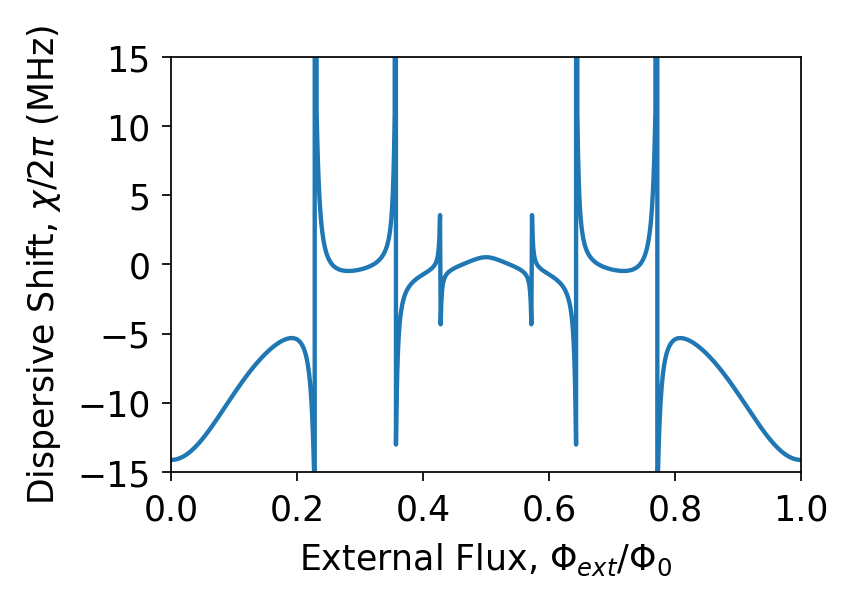

In [4]:
fig, ax = plt.subplots(ncols=1, nrows=1, dpi=250)

fig.subplots_adjust(bottom = 0.16, top=0.99, left=0.16, right=0.9, wspace=0.4, hspace=0.4)

fig.set_size_inches(3.40457, 2.0)
font = {'size' : 8}
mpl.rc('font', **font)

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(0.5)
ax.tick_params(width=0.5, which='both')
ax.tick_params(length=2.5, which='major')
ax.tick_params(length=1.5, which='minor')

ax.plot(phi_ext / mfq, np.array(chi), linewidth=1.25)

ax.set_xlim(0, 1)
ax.set_ylim(-15,15)

ax.set_xlabel(r"External Flux, $\Phi_{ext}/\Phi_0$")
ax.set_ylabel(r"Dispersive Shift, $\chi/2\pi$ (MHz)")


Text(0, 0.5, 'Qubit Frequency, $\\omega_{10}/2\\pi$ (MHz)')

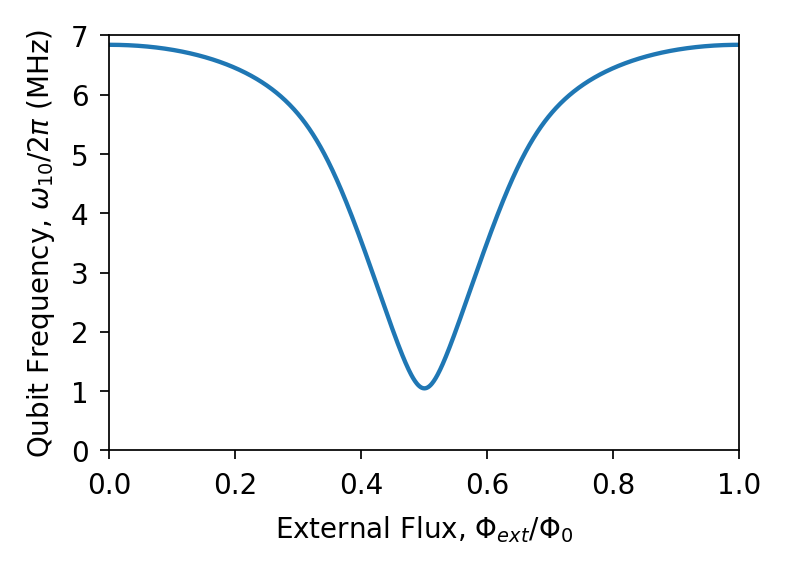

In [5]:
fig, ax = plt.subplots(ncols=1, nrows=1, dpi=250)

fig.subplots_adjust(bottom = 0.16, top=0.99, left=0.16, right=0.9, wspace=0.4, hspace=0.4)

fig.set_size_inches(3.40457, 2.0)
font = {'size' : 8}
mpl.rc('font', **font)

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(0.5)
ax.tick_params(width=0.5, which='both')
ax.tick_params(length=2.5, which='major')
ax.tick_params(length=1.5, which='minor')

ax.plot(phi_ext / mfq, np.array(qubitEdiff_r0), linewidth=1.25)

ax.set_xlim(0, 1)
ax.set_ylim(0,7)

ax.set_xlabel(r"External Flux, $\Phi_{ext}/\Phi_0$")
ax.set_ylabel(r"Qubit Frequency, $\omega_{10}/2\pi$ (MHz)")

# 2D maps to see energy dependence

### Constant $E_{J}$/$E_{C}$, $E_{J}$, and  $E_{C}$, and loop over $E_{L}$

In [ ]:
Ec = 1
Ej = 8

Eind = np.linspace(0.15, 2.15, 101)
phi_ext = np.linspace(0, mfq, 101)

chi = np.zeros((len(Eind), len(phi_ext)))
qubitEdiff_r0 = np.zeros((len(Eind), len(phi_ext)))

for n, phi in enumerate(tqdm(phi_ext, desc = "phi_ext loop")):
    for m, l in enumerate(tqdm(Eind, desc = "El loop")):
        phi_naught = ((8 * Ec) / l)**(1/4)
        n_op = (-1j / (math.sqrt(2) * phi_naught)) * (c - cdag)
        phi_op = (phi_naught / math.sqrt(2)) * (c + cdag)
        phi_op_HC = phi_op.dag()
        Cterm = 4 * Ec * (n_op)**2
        Lterm = (1/2) * l * phi_op**2
        Jterm = -Ej * ((1/2) * ((1j * (phi_op - phi)).expm()) + (1/2) * ((-1j * (phi_op_HC - phi)).expm()))
        H_flux = Jterm + Cterm + Lterm
        H_sys = tensor(H_flux, qeye(M)) + tensor(qeye(N), H_lc) + H_i
        states, energies, frequencies, chi_value, truncated_H = truncate_disshift(H_sys, resonator_num)
        chi[m][n] = chi_value.real * 1000 #MHz
        qubitEdiff_r0[m][n] = frequencies[0].real

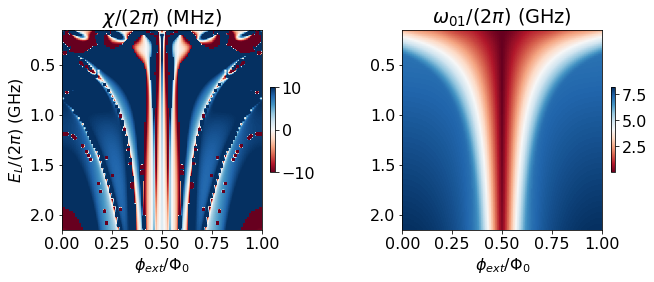

In [135]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,12))
fig.subplots_adjust(bottom = 0.16, top=0.99, left=0.16, right=0.8, wspace=0.6)
font = {'size' : 16}
plt.rc('font', **font)

im1 = ax1.imshow(chi, extent=[0,1,2.15,0.15], vmin=-10, vmax=10, cmap=plt.cm.RdBu)
ax1.set_title(r"$\chi/2\pi$ (MHz)")
fig.colorbar(im1, ax=ax1,fraction=0.02, pad=0.04)
ax1.set_xlabel(r"$\Phi_{ext}/\Phi_{0}$")
ax1.set_ylabel(r"$E_{L}/2\pi$ (GHz)")
ax1.set_aspect(0.5)

im2 = ax2.imshow(qubitEdiff_r0, extent=[0,1,2.15,0.15], cmap=plt.cm.RdBu)
ax2.set_title(r"$\omega_{01}/2\pi$ (GHz)")
fig.colorbar(im2, ax=ax2,fraction=0.02, pad=0.04)
ax2.set_xlabel(r"$\Phi_{ext}/\Phi_{0}$")
ax2.set_aspect(0.5)
plt.show()

### Constant $E_{J}$/$E_{C}$ (=5), and $E_{L}$, and loop over $E_{J}$ and $E_{C}$

In [ ]:
El = 0.5

ratio = 5
Ej = np.linspace(2.5, 7.5, 101)
phi_ext = np.linspace(0, mfq, 101)

chi = np.zeros((len(Ej), len(phi_ext)))
qubitEdiff_r0 = np.zeros((len(Ej), len(phi_ext)))

for n, phi in enumerate(tqdm(phi_ext, desc = "phi_ext loop")):
    for m, j in enumerate(tqdm(Ej, desc = "Ej loop")):
        phi_naught = ((8 * (j/ratio)) / El)**(1/4)
        n_op = (-1j / (math.sqrt(2) * phi_naught)) * (c - cdag)
        phi_op = (phi_naught / math.sqrt(2)) * (c + cdag)
        phi_op_HC = phi_op.dag() 
        Cterm = 4 * (j/ratio) * (n_op)**2
        Lterm = (1/2) * El * phi_op**2   
        Jterm = -j * ((1/2) * ((1j * (phi_op - phi)).expm()) + (1/2) * ((-1j * (phi_op_HC - phi)).expm()))
        H_flux = Jterm + Cterm + Lterm
        H_sys = tensor(H_flux, qeye(M)) + tensor(qeye(N), H_lc) + H_i
        states, energies, frequencies, chi_value, truncated_H = truncate_disshift(H_sys, resonator_num)
        chi[m][n] = chi_value.real * 1000 #MHz
        qubitEdiff_r0[m][n] = frequencies[0].real

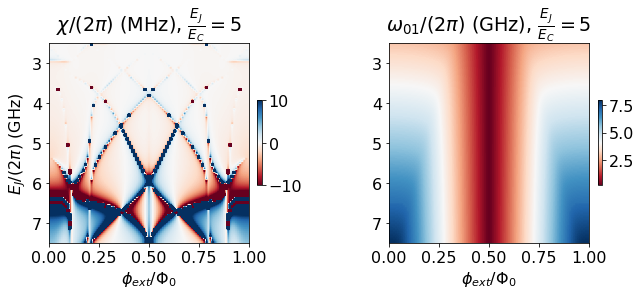

In [140]:
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(12,12))
fig.subplots_adjust(bottom = 0.16, top=0.99, left=0.16, right=0.8, wspace=0.6)
font = {'size' : 16}
plt.rc('font', **font)

im00 = ax[0].imshow(chi, extent=[0,1,7.5,2.5], vmin=-10, vmax=10, cmap=plt.cm.RdBu)
ax[0].set_title(r"$\chi/2\pi$ (MHz)")
fig.colorbar(im00, ax=ax[0],fraction=0.02, pad=0.04)
ax[0].set_xlabel(r"$\Phi_{ext}/\Phi_{0}$")
ax[0].set_ylabel(r"$E_{J}/2\pi$ (GHz)")
ax[0].set_aspect(0.2)

im01 = ax[1].imshow(qubitEdiff_r0, extent=[0,1,7.5,2.5], cmap=plt.cm.RdBu)
ax[1].set_title(r"$\omega_{01}/2\pi$ (GHz)")
fig.colorbar(im01, ax=ax[1],fraction=0.02, pad=0.04)
ax[1].set_xlabel(r"$\Phi_{ext}/\Phi_{0}$")
ax[1].set_aspect(0.2)

plt.show()

### Constant $E_{J}$ and $E_{L}$, and loop over $E_{C}$

In [141]:
El = 0.75
Ej = 8

Ec = np.linspace(0.5, 2.5, 101)
phi_ext = np.linspace(0, mfq, 101)

chi = np.zeros((len(Ec), len(phi_ext)))
qubitEdiff_r0 = np.zeros((len(Ec), len(phi_ext)))

for n, phi in enumerate(tqdm(phi_ext, desc = "phi_ext loop")):
    for m, b in enumerate(tqdm(Ec, desc = "Ec loop")):
        phi_naught = ((8 * b) / El)**(1/4)
        n_op = (-1j / (math.sqrt(2) * phi_naught)) * (c - cdag)
        phi_op = (phi_naught / math.sqrt(2)) * (c + cdag)
        phi_op_HC = phi_op.dag()
        Cterm = 4 * b * (n_op)**2
        Lterm = (1/2) * El * phi_op**2
        Jterm = -Ej * ((1/2) * ((1j * (phi_op - phi)).expm()) + (1/2) * ((-1j * (phi_op_HC - phi)).expm()))
        H_flux = Jterm + Cterm + Lterm
        H_sys = tensor(H_flux, qeye(M)) + tensor(qeye(N), H_lc) + H_i
        states, energies, frequencies, chi_value, truncated_H = truncate_disshift(H_sys, resonator_num)
        chi[m][n] = chi_value.real * 1000 #MHz
        qubitEdiff_r0[m][n] = frequencies[0].real

phi_ext loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ec loop:   0%|          | 0/101 [00:00<?, ?it/s]

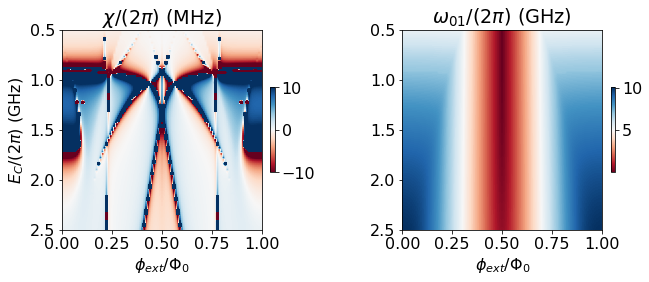

In [142]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,12))
fig.subplots_adjust(bottom = 0.16, top=0.99, left=0.16, right=0.8, wspace=0.6)
font = {'size' : 16}
plt.rc('font', **font)

im1 = ax1.imshow(chi, extent=[0,1,2.5,0.5], vmin=-10, vmax=10, cmap=plt.cm.RdBu)
ax1.set_title(r"$\chi/2\pi$ (MHz)")
fig.colorbar(im1, ax=ax1,fraction=0.02, pad=0.04)
ax1.set_xlabel(r"$\Phi_{ext}/\Phi_{0}$")
ax1.set_ylabel(r"$E_{C}/2\pi$ (GHz)")
ax1.set_aspect(0.5)

im2 = ax2.imshow(qubitEdiff_r0, extent=[0,1,2.5,0.5], cmap=plt.cm.RdBu)
ax2.set_title(r"$\omega_{01}/2\pi$ (GHz)")
fig.colorbar(im2, ax=ax2,fraction=0.02, pad=0.04)
ax2.set_xlabel(r"$\Phi_{ext}/\Phi_{0}$")
ax2.set_aspect(0.5)

plt.show()

### Constant $E_{C}$ and $E_{L}$, and loop over $E_{J}$

In [143]:
Ec = 0.75
El = 0.5

Ej = np.linspace(3, 10, 101)
phi_ext = np.linspace(0, mfq, 101)

chi = np.zeros((len(Ej), len(phi_ext)))
qubitEdiff_r0 = np.zeros((len(Ej), len(phi_ext)))

for n, phi in enumerate(tqdm(phi_ext, desc = "phi_ext loop")):
    for m, j in enumerate(tqdm(Ej, desc = "Ej loop")):
        phi_naught = ((8 * Ec) / El)**(1/4)
        n_op = (-1j / (math.sqrt(2) * phi_naught)) * (c - cdag)
        phi_op = (phi_naught / math.sqrt(2)) * (c + cdag)
        phi_op_HC = phi_op.dag()
        Cterm = 4 * Ec * (n_op)**2
        Lterm = (1/2) * El * phi_op**2
        Jterm = -j * ((1/2) * ((1j * (phi_op - phi)).expm()) + (1/2) * ((-1j * (phi_op_HC - phi)).expm()))
        H_flux = Jterm + Cterm + Lterm
        H_sys = tensor(H_flux, qeye(M)) + tensor(qeye(N), H_lc) + H_i
        states, energies, frequencies, chi_value, truncated_H = truncate_disshift(H_sys, resonator_num)
        chi[m][n] = chi_value.real * 1000 #MHz
        qubitEdiff_r0[m][n] = frequencies[0].real

phi_ext loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

Ej loop:   0%|          | 0/101 [00:00<?, ?it/s]

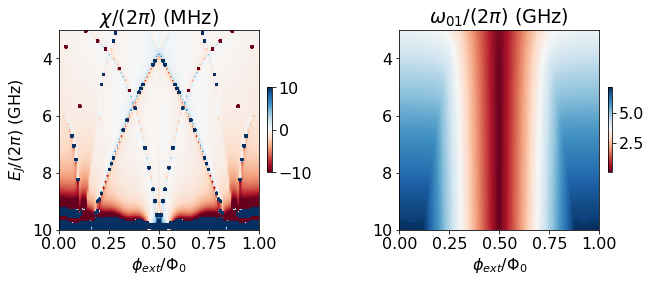

In [145]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,12))
fig.subplots_adjust(bottom = 0.16, top=0.99, left=0.16, right=0.8, wspace=0.6)
font = {'size' : 16}
plt.rc('font', **font)

im1 = ax1.imshow(chi, extent=[0,1,10,3], vmin=-10, vmax=10, cmap=plt.cm.RdBu)
ax1.set_title(r"$\chi/2\pi$ (MHz)")
fig.colorbar(im1, ax=ax1,fraction=0.02, pad=0.04)
ax1.set_xlabel(r"$\Phi_{ext}/\Phi_{0}$")
ax1.set_ylabel(r"$E_{J}/2\pi$ (GHz)")
ax1.set_aspect(1/7)

im2 = ax2.imshow(qubitEdiff_r0, extent=[0,1,10,3], cmap=plt.cm.RdBu)
ax2.set_title(r"$\omega_{01}/2\pi$ (GHz)")
fig.colorbar(im2, ax=ax2,fraction=0.02, pad=0.04)
ax2.set_xlabel(r"$\Phi_{ext}/\Phi_{0}$")
ax2.set_aspect(1/7)
plt.show()